# Synthèse Complète de notre Matcha-TTS 


In [ ]:
# 1. Imports & Configuration des Chemins
%matplotlib inline
import sys
import os
import glob
import json
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Ajout des chemins locaux comme dans vos scripts
sys.path.append(os.getcwd())       # Racine du projet
sys.path.append('./hifi_gan')      # Dossier HiFi-GAN
sys.path.append('./matcha')        # Dossier Matcha

# Imports spécifiques au projet
from matcha.models.matcha_tts import MatchaTTS
from matcha.text_to_ID.text_to_sequence import text_to_sequence
from matcha.utils.data_download.utils import download_pretrained_model 

# Imports HiFi-GAN (avec gestion d'erreur si le dossier manque)
try:
    from hifi_gan.models import Generator as HiFiGAN
    from hifi_gan.env import AttrDict
    HIFIGAN_AVAILABLE = True
except ImportError:
    print(" Module HiFi-GAN non trouvé. Assurez-vous d'avoir le dossier 'hifi_gan' ou 'matcha/hifigan_wrapper.py'.")
    HIFIGAN_AVAILABLE = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {DEVICE}")

Device utilisé : cpu


In [2]:
# 2. Configuration

# Paramètres de génération
N_STEPS = 10        # Nombre d'étapes pour le Solver ODE (10-50)
TEMPERATURE = 0.667 # Variance du bruit initial
LENGTH_SCALE = 1.0  # Vitesse de parole (1.0 = normal, 0.8 = rapide)

# Chemins (A adapter si besoin)
LOGS_DIR = "lightning_logs"
HIFIGAN_CONFIG = './checkpts/config.json'      
MODEL_URL_HIFIGAN = "https://github.com/Raph1821/Matcha-TTS-etu-UPMC-ENSAM/releases/download/v1.0/generator_v1"
HIFIGAN_CHECKPT = './checkpts/generator_v1' # Mettez le vrai nom de votre .pt

MODEL_URL = "https://github.com/Raph1821/Matcha-TTS-etu-UPMC-ENSAM/releases/download/v1.0/matcha_final.ckpt"
CHECKPOINT_PATH = "checkpoints_matcha/pretrained_ljspeech.ckpt"  # mettre None si on veut le dernier checkpoint du dossier lightning_logs

download_pretrained_model(MODEL_URL, CHECKPOINT_PATH)
download_pretrained_model(MODEL_URL_HIFIGAN, HIFIGAN_CHECKPT)

 Le modèle existe déjà à : checkpoints_matcha/pretrained_ljspeech.ckpt
 Le modèle existe déjà à : ./checkpts/generator_v1


In [ ]:
# 3. Fonctions Utilitaires (Copiées de vos scripts)

def get_latest_checkpoint(logs_dir="lightning_logs"):
    """Trouve le dernier checkpoint .ckpt généré par l'entraînement."""
    files = glob.glob(f"{logs_dir}/**/*.ckpt", recursive=True)
    if not files:
        raise FileNotFoundError(f"Aucun checkpoint trouvé dans {logs_dir}")
    latest_file = max(files, key=os.path.getmtime)
    print(f" Checkpoint Matcha trouvé : {latest_file}")
    return latest_file

def load_hifigan(checkpoint_path, config_path, device):
    """Charge le modèle HiFi-GAN."""
    if not os.path.exists(config_path) or not os.path.exists(checkpoint_path):
        raise FileNotFoundError("Fichiers HiFi-GAN manquants !")

    with open(config_path) as f:
        data = f.read()
    json_config = json.loads(data)
    h = AttrDict(json_config)
    
    hifigan = HiFiGAN(h).to(device)
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    if 'generator' in state_dict:
        hifigan.load_state_dict(state_dict['generator'])
    else:
        hifigan.load_state_dict(state_dict)
        
    hifigan.eval()
    hifigan.remove_weight_norm()
    return hifigan

In [ ]:
# 4. Chargement des Modèles

# 1. Matcha TTS
ckpt_path = CHECKPOINT_PATH if CHECKPOINT_PATH else get_latest_checkpoint()
matcha_model = MatchaTTS.load_from_checkpoint(ckpt_path, map_location=DEVICE)
matcha_model.eval()
matcha_model.to(DEVICE)
print(" Matcha-TTS chargé !")

# 2. HiFi-GAN
print("Chargement de HiFi-GAN...")
    
# 1. On lit la configuration
with open(HIFIGAN_CONFIG) as f:
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config) # Utilisation de la classe AttrDict de env.py
    
# 2. On initialise le générateur
vocoder = HiFiGAN(h).to(DEVICE)
    
# 3. On charge les poids
# Note: Parfois le checkpoint contient tout un dictionnaire, parfois juste les poids.
# Le code officiel fait state_dict['generator']
state_dict_g = torch.load(HIFIGAN_CHECKPT, map_location=DEVICE)
vocoder.load_state_dict(state_dict_g['generator'])
    
vocoder.eval()
vocoder.remove_weight_norm() # Nettoyage pour l'inférence
print("HiFi-GAN chargé !")

c:\Users\minha\anaconda3\envs\matcha-tts\lib\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.6
c:\Users\minha\anaconda3\envs\matcha-tts\lib\site-packages\diffusers\models\lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


✅ Matcha-TTS chargé !
Chargement de HiFi-GAN...


c:\Users\minha\anaconda3\envs\matcha-tts\lib\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Removing weight norm...
HiFi-GAN chargé !


In [10]:
# 4. Paramètres de Génération

TEXTE = "Hello, here is our first synthesis with Matcha TTS! How are you doing today? We hope you enjoy this demo."
STEPS = 50           # Nombre d'étapes de diffusion (10-50)
TEMPERATURE = 0.667  # Variation (0.667 est standard)
LENGTH_SCALE = 1.0   # Vitesse (1.0 = normal, <1.0 = rapide)

print(f"Texte à synthétiser : '{TEXTE}'")

Texte à synthétiser : 'Hello, here is our first synthesis with Matcha TTS! How are you doing today? We hope you enjoy this demo.'


 Génération du spectrogramme Mel...
 Spectrogramme généré !
 Spectrogramme sauvegardé dans 'generated_audio_comparison/mel_spectrogram_display.png'


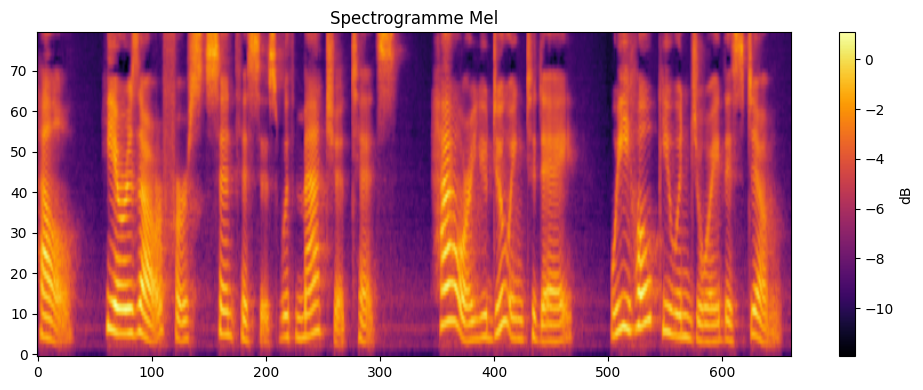

In [16]:
# 5. Génération du Mel-Spectrogramme
sequence = text_to_sequence(TEXTE, ["english_cleaners"])
x = torch.tensor([sequence], dtype=torch.long, device=DEVICE)
x_lengths = torch.tensor([len(sequence)], dtype=torch.long, device=DEVICE)

print(" Génération du spectrogramme Mel...")
with torch.no_grad():
    # Utilisation directe de la méthode synthesise du modèle
    # Elle gère tout : encodeur, alignement, décodeur (CFM)
    output = matcha_model.synthesise(
        x=x, 
        x_lengths=x_lengths, 
        n_timesteps=STEPS,
        temperature=TEMPERATURE,
        length_scale=LENGTH_SCALE
    )
    
# Récupération du Mel
# output['mel'] est déjà dénormalisé par le modèle si les stats sont présentes
mel = output['mel']
    
print(" Spectrogramme généré !")
    
# Affichage du spectrogramme
mel_cpu = mel.squeeze().cpu().numpy()
plt.figure(figsize=(10, 4))
plt.imshow(mel_cpu, origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label='dB')
plt.title("Spectrogramme Mel")
plt.tight_layout()
plt.savefig('generated_audio_comparison/mel_spectrogram_display.png', dpi=100, bbox_inches='tight')  # Sauvegarder l'image
print(" Spectrogramme sauvegardé dans 'generated_audio_comparison/mel_spectrogram_display.png'")
display(plt.gcf())  # Afficher dans le notebook
plt.close()

In [17]:
# 6. Vocoder (Mel -> Audio) et Écoute
print("Synthèse audio avec Hifi-Gan :")
with torch.no_grad():
        # Le modèle attend un tenseur de forme [Batch, Canaux, Temps]
        # output['mel'] est déjà [1, 80, T], c'est parfait.
        
        # Génération
        audio = vocoder(mel)
        
        # Le résultat est [1, 1, T_audio], on veut juste [T_audio] ou [1, T_audio] pour sauvegarder
        audio = audio.squeeze()
        
        # Normalisation pour éviter la saturation (clipping)
        audio = audio.clamp(-1, 1)
        
        # Conversion en CPU pour la sauvegarde
        audio_cpu = audio.cpu()

display(Audio(audio_cpu, rate=22050))


Synthèse audio avec Hifi-Gan :
